<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/RNN_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**순환신경망**

순환신경망을 통해서 문장의 특성을 분류하는 알고리즘이다. 총 4개이다.
1) 저수준의 API, 2) 고수준 API (w/임베딩), 3) LSTM (w/임베딩)  4) Conv1D (w/임베딩) 

순환신경망에서는 뉴런을 셀이라고 부른다. 아래의 예는 한개의 순환층으로 구성된 RNN이다. 이번 예는 저수준의 API로 실행한 사례이다.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb

빈출 단어 중 top 20개를 제외하고 분석에 사용될 전체 단어수를 100개로 한정

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [ ]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [ ]:
word_to_index = imdb.get_word_index()

word_to_index['movie']

17

In [ ]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w-3], end=' ') # 3 이상 부터 영어단어 이다

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [3]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [ ]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [ ]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [4]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

샘플만다 문장의 길이가 다르므로 최대 100개 단어만 포함되도록 전처리 한다

In [5]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [6]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


(100, 20000)


sequence.pad_sequence 함수는 단어수가 100개가 않될 때, 앞쪽부터 0으로 채워준다. **0번은 무슨 문자를 의미할까?**

In [ ]:
print(x_train_seq[1])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 54 39 27 35 35 56 27 29 80 27 27 46 23
 35 64 86 65 35 22 63 73 29 22 82 34 50 26 21 47 30 97 83 76 69 86 31 61
 49 99 85 85 26 73 81 87 53 26 53 74 26 53 62 28 21 50 44 93 22 39 34 21
 45 87 20 32]


In [ ]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

하나의 샘플은 최대길이가 100 단어이고, 이를 onehot으로 바꾸면 (20000,100) 메트릭스 구조는 (20000, 100, 100)로 전환되고 마지막 100은 0 또는 1로만 구성되고 두번째 100은 마지막 100개의 0,1로 구성된 리스트가 100개 모여있는 구조이다.  

순환신경망에서는 타임스텝으로 전체 샘플이 하나의 타임스템 set를 구성해서 동시에 순환층의 셀로 입력된다. 이를 위해서 입력데이터의 변경이 필요하고 numpy에서는 np.swapaxes(x, 0, 1)을 사용한다. 이렇게 하면 0,1이 100개로 구성된 20000개의 샘플이 만들어 지고 (20000,100) 이후 100개의 타입스텝을 구성하는 매트릭스가 만들어 진다. (100,(20000,100)) --> (100, 20000, 100)
 

In [ ]:
x_train_onehot_seq_test = np.swapaxes(x_train_onehot, 0, 1)
print(x_train_onehot_seq_test.shape)
print(x_train_onehot_seq_test[0][1999]) # 1999번째 샘플의 0번 타입스텝 자료 이다.

(100, 20000, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


**tf.transpose(x, [1,0,2])와 np.swapaxes(x, 0,1)은 같은 기능을 한다**
아래 데이터를 보면 1999번째 샘플의 첫번째 단어가 윗 칸의 결과와 동일하다는 것을 알수 있다

In [ ]:
x_train_onehot_seq_transpose = tf.transpose(x_train_onehot, [1, 0, 2])
print(x_train_onehot_seq_transpose.shape)
print(x_train_onehot_seq_transpose[0][1999])

(100, 20000, 100)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], shape=(100,), dtype=float32)


In [ ]:
h_test = None
h_test = [tf.Variable(np.zeros((3,4)))]
print(h_test)
h_test.append([9,10])
print(h_test[-1])
h_test.append([11,20])
print(h_test[-1])

[<tf.Variable 'Variable:0' shape=(3, 4) dtype=float64, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])>]
[9, 10]
[11, 20]


In [ ]:
y_train1 = y_train.reshape(-1,1)
print(y_train1.shape[1])

1


**아래는 저수준의 API를 이용하여 RNN을 수행하기 위한 핵심부분이다.**

In [ ]:
def gen_batch1(x, y, batch_size = 32):
    length = len(x)
    bins = length // batch_size # 미니배치 횟수
    if length % batch_size:
      bins += 1                    # 나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = batch_size * i
      end = batch_size * (i + 1)
      yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

orth = tf.initializers.Orthogonal()
g = tf.initializers.GlorotUniform()

n_cells = 10
n_classes = 1
n_features = 100

w1h = tf.Variable(orth((n_cells, n_cells))) # (셀 개수, 셀 개수)
w1x = tf.Variable(g((n_features, n_cells))) # (특성 개수, 셀 개수)
b1 = tf.Variable(np.zeros(n_cells), dtype=float)                # 은닉층의 크기
w2 = tf.Variable(g((n_cells, n_classes)))   # (셀 개수, 클래스 개수), 클래스는 최종 출력층의 클래스를 의미한다. 1,0으로 구분되면 1이다.
b2 = tf.Variable(np.zeros(n_classes), dtype=float)


for x_batch, y_batch in gen_batch1(x_train_onehot, y_train):
  seq = tf.transpose(x_batch, [1, 0, 2])
  h = [tf.zeros((32, n_cells))] ## np.zeros와 tf.zeros는 동일한 역할을 한다. 순환층의 순환 입력인 h.shape는 (샘플수, 셀수)이며 여기서 샘플은 배치로 들어오는 샘플 수 이다. 
  # h[-1].shape는 (32,10)이다.
  # seq.shape는 (타입스텝수, 배치샘플수, 피처의 수)이고 이를 for문으로 돌리면 모든 배치의 피처로 구성된 매트릭스를 모든 타입스템이 종료될때 까지 종료한다.
  # 요약하면 아래는 100번의 타입스템을 반복하는 form 문이다. 
  for x in seq: # x.shape=(32,100), tf.matmul(x, w1x)의 shape는 (32,10) 즉 (배치의 샘플 수, 셀수)
    z1 = tf.matmul(x, w1x) + tf.matmul(h[-1], w1h) + b1
    h1 = tf.math.tanh(z1)
    h.append(h1)
    z2 = tf.matmul(h, w2) + b2
  print(z2)
  break




tf.Tensor(
[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[-0.1134952 ]
  [-0.1134952 ]
  [-0.1134952 ]
  ...
  [ 0.10696866]
  [-0.1134952 ]
  [-0.1134952 ]]

 [[-0.37890983]
  [-0.37890983]
  [-0.37890983]
  ...
  [-0.19381759]
  [-0.37890983]
  [-0.37890983]]

 ...

 [[ 0.20559448]
  [-0.80267304]
  [-0.83811986]
  ...
  [ 0.48204535]
  [ 0.20198806]
  [-0.23623969]]

 [[ 0.2635964 ]
  [-0.96342784]
  [-0.77399445]
  ...
  [-0.19330658]
  [ 0.39716306]
  [ 0.08583396]]

 [[ 0.05638719]
  [-0.21821207]
  [ 0.38992298]
  ...
  [-0.7803012 ]
  [-0.01133937]
  [-0.09685934]]], shape=(101, 32, 1), dtype=float32)


In [ ]:
import tensorflow as tf

In [ ]:
class RecurrentNetwork():
    
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells     # 셀 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1h = None            # 은닉 상태에 대한 가중치
        self.w1x = None            # 입력에 대한 가중치
        self.b1 = None             # 순환층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.h = None              # 순환층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률

    def forpass(self, x):
        self.h = [tf.zeros((x.shape[0], self.n_cells))]   # 은닉 상태를 초기화합니다. 여기가 중요하다
        
        # self.h = [np.zeros((x.shape[0], self.n_cells))]   # 은닉 상태를 초기화합니다.
        # h값은 순환층의 하나의 셀의 출렬값이다. h의 shape는 (샘플수, 셀수)로 초기화 된다.
        # 왜냐하면 타입스텝별로 전체의 샘플이 은닉층의 셀로 입력되기 때문이다. 메트릭스의 표현으로는 (100, 20000) * (20000, 셀수)
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = tf.transpose(x, [1, 0, 2])
        # seq = np.swapaxes(x, 0, 1)
        # 순환 층의 선형 식을 계산합니다. 
        # seq.shape = (100, batch_size, 100) 형식이다. 즉 전체 샘플 중에서 batch로 선택된 데이터를 (타입스텝, 배치, 피쳐)로 뽑은 것이고, x는 타입스텝을 제외한(배치, 피처)이다.
        # 즉 선택된 배치의 (배치, 피쳐)를 모든 타입스템에 걸처서 for문을 돌리는 구조이다
        # 첫번째 타입스텝 input은 h로 기록되고 다음 타입스텝에 입력으로 다시 들어간다.
        # 최종적으로 마지막 타입스텝까지 처리된 후 한개의 출력증으로 들어간다. 즉 여러개의 타입스텝 자료가 순환층을 거쳐서 한개의 출력층으로 들어가는 다대일 구조이다.
        for x in seq:                       
            z1 = tf.matmul(x, self.w1x) + tf.matmul(self.h[-1], self.w1h) + self.b1
            h = tf.math.tanh(z1)                    # 활성화 함수를 적용합니다.
            self.h.append(h)                   # 역전파를 위해 은닉 상태 저장합니다.
            z2 = tf.matmul(h, self.w2) + self.b2  # 출력층의 선형 식을 계산합니다.
        return z2


    
    def sigmoid(self, z):
        #z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + tf.math.exp(-z))              # 시그모이드 계산
        return a
    
    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()

        self.w1h = tf.Variable(orth_init((self.n_cells, self.n_cells))) # (셀 개수, 셀 개수)
        self.w1x = tf.Variable(glorot_init((n_features, self.n_cells))) # (특성 개수, 셀 개수)
        self.b1 = tf.Variable(np.zeros(self.n_cells), dtype=float)                # 은닉층의 크기
        self.w2 = tf.Variable(glorot_init((self.n_cells, n_classes)))   # (셀 개수, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)
        
        
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        self.init_weights(x.shape[2], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')  # 반복 횟수만큼 점을 찍는다.
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)


    def get_loss(self, x, y):
        z = self.forpass(x) 
        a = self.sigmoid(z)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_sum(-(y*tf.math.log(a) + (1-y)*tf.math.log(1-a)))
        return loss.numpy()


    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
 
    def training(self, x, y):
       m = len(x) # 샘플 개수를 저장합니다.
       with tf.GradientTape() as tape:
         z = self.forpass(x)       # 정방향 계산을 수행합니다.
         a = self.sigmoid(z)       # 활성화 함수를 적용합니다.
            # 손실을 계산합니다.
         loss = tf.reduce_sum(-(y*tf.math.log(a) + (1-y)*tf.math.log(1-a)))

       weights_list = [self.w1h, self.w1x, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다. loss를 특정 weights_list에서 미분한 미분값을 grads로 저정한다.
       grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
       self.optimizer.apply_gradients(zip(grads, weights_list))
       
 

   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return z > 0                 # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)                # 활성화 함수를 적용합니다.
        #a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        val_loss = tf.reduce_mean(-(y_val*tf.math.log(a) + (1-y_val)*tf.math.log(1-a)))
        self.val_losses.append(val_loss)

In [ ]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=10, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
import matplotlib.pyplot as plt

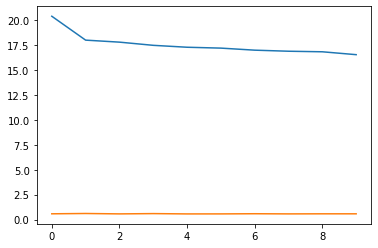

In [ ]:
plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [ ]:
rn.score(x_val_onehot, y_val)

0.7024

**Sequential model로 RNN을 구현**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

아래는 32개 셀로 구성되고 100개로 원핫코딩된 자료를 다룬다.

순환망의 투입되는 x는 (타입탭수, 배치샘플 수, 특성개수)이며 타입스텝수 만큼 반복되어 w1x와 matmul을 반복하여 h을 산출한다. 그러나 SimpleRNN에서는 당초 원핫코딩 자료로 투입된다. 따라서 (샘플수, 각 샘플의 최대 단어수, 각 샘플의 최대 단어수)이다.
w1x는 (특성 개수, 셀 개수) = (100, 32) = 3200
b1은 셀수 = 32 
w1h는 (셀개수, 셀 개수) = (32, 32) = 1024
w2는 (셀개수, 클래스수=1) = (32, 1)
b2는 클래스 수 = 1

순환층의 총 파라미터는 = 3200 + 32 + 1024 = 4256
덴스층은 32 + 1 = 33

In [ ]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100))) # 맨앞의 32는 셀의 개수이다. 타입스템의 크기가 100, one_hotcoding의 크기(피처의 크기)가 100이다.
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 11s 17ms/step - loss: 0.7010 - accuracy: 0.5210 - val_loss: 0.6940 - val_accuracy: 0.5344
Epoch 2/20
625/625 [==============================] - 11s 18ms/step - loss: 0.6770 - accuracy: 0.5758 - val_loss: 0.6908 - val_accuracy: 0.5626
Epoch 3/20
625/625 [==============================] - 11s 17ms/step - loss: 0.6525 - accuracy: 0.6226 - val_loss: 0.6242 - val_accuracy: 0.6622
Epoch 4/20
625/625 [==============================] - 11s 17ms/step - loss: 0.6310 - accuracy: 0.6464 - val_loss: 0.6020 - val_accuracy: 0.6872
Epoch 5/20
625/625 [==============================] - 11s 17ms/step - loss: 0.6153 - accuracy: 0.6679 - val_loss: 0.6727 - val_accuracy: 0.6270
Epoch 6/20
625/625 [==============================] - 11s 17ms/step - loss: 0.6055 - accuracy: 0.6795 - val_loss: 0.6036 - val_accuracy: 0.6822
Epoch 7/20
625/625 [==============================] - 11s 17ms/step - loss: 0.5963 - accuracy: 0.6834 - val_loss: 0.6070 - val_accuracy:

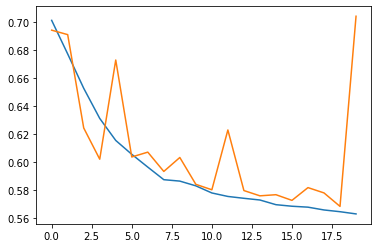

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

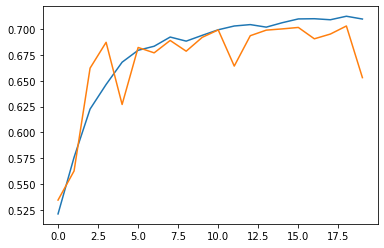

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)
print(accuracy)

0.652999997138977


**임베팅을 활용한 분석**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding

In [ ]:
np.random.seed(42)
random_index = np.random.permutation(25000)

1000개의 단어를 가지고 분석하는 예이다.

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

임베딩은 단어에 실수의 벡터를 부여하는데, 유사한 단어간 벡터의 거리는 가깝고, 관계가 없는 단어의 벡터간의 거리는 멀다. 1000개의 단어를 임베딩하고 각 벡터의 길이는 32이다.

In [ ]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 8)                 328       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                        validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 12s 20ms/step - loss: 0.6059 - accuracy: 0.6493 - val_loss: 0.4902 - val_accuracy: 0.7794
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4562 - accuracy: 0.7976 - val_loss: 0.4698 - val_accuracy: 0.7902
Epoch 3/10
625/625 [==============================] - 11s 18ms/step - loss: 0.3987 - accuracy: 0.8301 - val_loss: 0.4742 - val_accuracy: 0.8032
Epoch 4/10
625/625 [==============================] - 12s 19ms/step - loss: 0.3506 - accuracy: 0.8548 - val_loss: 0.4560 - val_accuracy: 0.8002
Epoch 5/10
625/625 [==============================] - 12s 18ms/step - loss: 0.3143 - accuracy: 0.8734 - val_loss: 0.5105 - val_accuracy: 0.7568
Epoch 6/10
625/625 [==============================] - 11s 18ms/step - loss: 0.2893 - accuracy: 0.8838 - val_loss: 0.4825 - val_accuracy: 0.7956
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2587 - accuracy: 0.9007 - val_loss: 0.4912 - val_accuracy:

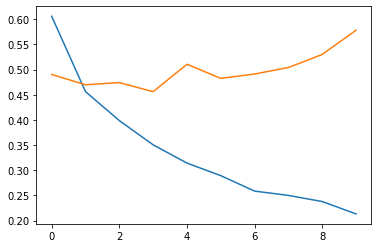

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

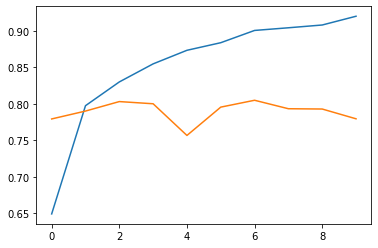

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.7796000242233276


**다음은 embedding만 하는 사례이다.**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
t  = Tokenizer()
fit_text = "The earth is an an awesome place live"
t.fit_on_texts([fit_text])
print("word_index : ",t.word_index) # 딕셔너리로 단어에 번호를 부여한다. fit_text에서 an이 반복되었지만, 단어 딕셔너리는 중복이 없다.


test_text = "The earth is an great place live"
sequences = t.texts_to_sequences([test_text])[0]

print("sequences : ",sequences) # great는 단어 집합(vocabulary)에 없으므로 출력되지 않는다.


word_index :  {'an': 1, 'the': 2, 'earth': 3, 'is': 4, 'awesome': 5, 'place': 6, 'live': 7}
sequences :  [2, 3, 4, 1, 6, 7]


In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 전처리가 끝나서 각 단어에 대한 정수 인코딩이 끝났다고 가정하고, 3개의 데이터를 입력으로 합니다.
# 첫째는 ['an', 'the', 'earth'] 세째는 ['live', 'place']를 의미한다. 길이를 3개로 맞추고 부족할 경우 앞에 "0"값을 주지만 아무런 의미가 없다.
pad_sequences([[1, 2, 3], [3, 4, 5, 6], [7, 6]], maxlen=3, padding='pre')


array([[1, 2, 3],
       [4, 5, 6],
       [0, 7, 6]], dtype=int32)

다음은 전체 단어수가 7이고 이를 길이가 5인 벡터로 임베딩을 하는 것이다.
이는 실제 단어가 무엇인가와는 관계없이 단어에 임의의 벡터를 할당하는 것과 같다

In [55]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import Embedding

model2 = Sequential()

model2.add(layers.Embedding(10, 5)) # 10은 input_dim이고 이는 모델에서 처리하고자 하는 단어수 보다는 커야 한다., 5는 output_dim  
model2.compile(optimizer='adam', loss='categorical_crossentropy')

In [56]:
data1 = [1,2,3]
data2 = [2,1,3]


In [57]:
output_array1 = model2.predict(data1)
output_array2 = model2.predict(data2)

In [58]:
print(output_array1)
print(output_array2)

[[[-0.00971066 -0.04074216 -0.04417323  0.04509917  0.02864157]]

 [[ 0.04664097  0.03898991 -0.04298136  0.01196374  0.03897074]]

 [[-0.03771245  0.01269343 -0.03957025  0.01165205 -0.02741113]]]
[[[ 0.04664097  0.03898991 -0.04298136  0.01196374  0.03897074]]

 [[-0.00971066 -0.04074216 -0.04417323  0.04509917  0.02864157]]

 [[-0.03771245  0.01269343 -0.03957025  0.01165205 -0.02741113]]]


In [59]:
print(model2.predict([0,1,2]))

[[[-0.01755292  0.01414279  0.03170024  0.03693798 -0.02634794]]

 [[-0.00971066 -0.04074216 -0.04417323  0.04509917  0.02864157]]

 [[ 0.04664097  0.03898991 -0.04298136  0.01196374  0.03897074]]]


In [60]:
# 임베딩의 가중치를 가져오는데 이 경우 bias는 계산하지 않고, 단어들을 벡터에 할당한다
model2.layers[0].get_weights()

[array([[-0.01755292,  0.01414279,  0.03170024,  0.03693798, -0.02634794],
        [-0.00971066, -0.04074216, -0.04417323,  0.04509917,  0.02864157],
        [ 0.04664097,  0.03898991, -0.04298136,  0.01196374,  0.03897074],
        [-0.03771245,  0.01269343, -0.03957025,  0.01165205, -0.02741113],
        [ 0.04328029, -0.04783683,  0.00267706,  0.01441178, -0.04544692],
        [-0.01670723,  0.00697714, -0.04343083,  0.04523421, -0.00831247],
        [-0.034885  ,  0.03328867,  0.01348536,  0.02110629, -0.04052256],
        [-0.04081003, -0.02262347,  0.0433885 ,  0.04700032,  0.03983456],
        [ 0.02882843, -0.02970421,  0.01031207, -0.01046051,  0.03583744],
        [ 0.03560284,  0.00938358, -0.02313477, -0.04240362,  0.04490108]],
       dtype=float32)]

**LSTM 활용**

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                         validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 18s 29ms/step - loss: 0.4520 - accuracy: 0.7920 - val_loss: 0.3693 - val_accuracy: 0.8390
Epoch 2/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3315 - accuracy: 0.8613 - val_loss: 0.3526 - val_accuracy: 0.8432
Epoch 3/10
625/625 [==============================] - 18s 28ms/step - loss: 0.3094 - accuracy: 0.8705 - val_loss: 0.3718 - val_accuracy: 0.8398
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2922 - accuracy: 0.8796 - val_loss: 0.3646 - val_accuracy: 0.8402
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2761 - accuracy: 0.8850 - val_loss: 0.3996 - val_accuracy: 0.8416
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2686 - accuracy: 0.8883 - val_loss: 0.3879 - val_accuracy: 0.8396
Epoch 7/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2554 - accuracy: 0.8947 - val_loss: 0.4045 - val_accuracy:

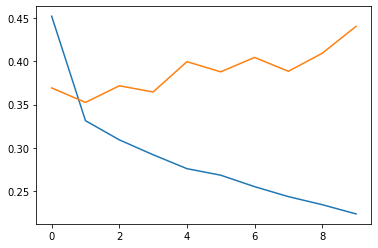

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

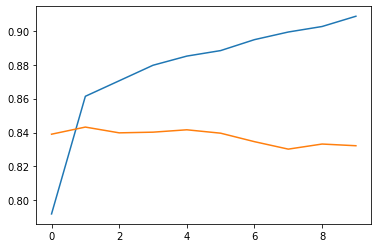

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8321999907493591


**다음은 1D ConvNet을 활용한 방법이다.**
연산이 구조가 간단한 만큼 포함되는 단어의 수를 500개로 늘리고, 임베팅의 벡터크기도 10000개로 하였다.

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [30]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

In [49]:
from tensorflow.keras.preprocessing import sequence

max_features = 1000
max_len=500
x_train_seq = sequence.pad_sequences(x_train, maxlen=max_len)
x_val_seq = sequence.pad_sequences(x_val, maxlen=max_len)

In [50]:
print(x_train_seq.shape)

(20000, 500)


In [51]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [52]:
model = Sequential()

model.add(layers.Embedding(max_features, 128, input_length=max_len)) # max_features는 input_dim, 128은 각 임베딩 벡터의 크기, input_length는 한번에 학습시킬 단어의 크기이다
 # 임배딩 층의 경우 모델에서 처리해야 할 단어수는 최대 500개이므로 input_dim는 500보다 크면 된다.
model.add(layers.Conv1D(32, 7, activation = 'relu')) # 합성곱 층의 셀은 32개로 구성되고 7개로 구성된 필러를 가진다.
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 6, activation='relu'))
model.add(layers.GlobalMaxPooling1D())  # Global Max Pooling은 합성층 전체를 대상으로 평균값을 리턴한다. 따라서 윈도의크기를 정하지 않는다.
model.add(layers.Dense(1))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 128)          128000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 93, 32)            6176      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 162,913
Trainable params: 162,913
Non-trainable params: 0
_______________________________________________

In [53]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train_seq, y_train, epochs=10, batch_size=128)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
20000/20000 [==============================] - 52s 3ms/step - loss: 0.7236 - acc: 0.5389
Epoch 2/10
20000/20000 [==============================] - 52s 3ms/step - loss: 0.6237 - acc: 0.6646
Epoch 3/10
20000/20000 [==============================] - 52s 3ms/step - loss: 0.5944 - acc: 0.6939
Epoch 4/10
20000/20000 [==============================] - 52s 3ms/step - loss: 0.5796 - acc: 0.7095
Epoch 5/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.5686 - acc: 0.7170
Epoch 6/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.5496 - acc: 0.7301
Epoch 7/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.5413 - acc: 0.7288
Epoch 8/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.5289 - acc: 0.7419
Epoch 9/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.5222 - acc: 0.7468
Epoch 10/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.4906 - acc: 0.7627

In [54]:
print(history.history['acc'])

[0.5389, 0.6646, 0.69395, 0.70945, 0.717, 0.73005, 0.7288, 0.74185, 0.7468, 0.7627]
